<a href="https://colab.research.google.com/github/Pulkit-m/COSD_Image_segmentation/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir(path= '/content/drive/MyDrive/COSD Image Segmentation')
os.getcwd()

'/content/drive/MyDrive/COSD Image Segmentation'

Importing Packages

In [3]:
import torch 
import os
import torch.nn as nn
import torch.optim as optim
import math
import os
import copy
import random
import numpy as np
import pandas as pd
from unet.unet_model import UNet
from DataLoader import COSD_Dataset_Loader, ToTensor, Generate_csv_logs_for_images
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import matplotlib
import matplotlib.pyplot as plt 



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [6]:


def dataset_train_test_split(dataset,split_ratio=0.15):
    """
        Returns a dictionary with keys 'train', 'val'
        returned objects can be unpacked and directly passed into torch.utils.data.DataLoader() function
    """
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=split_ratio)
    # print(train_idx)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


def visualizeData(dataset, index = 1, num = 3 ,show = False):
    plt.figure(figsize=(10,4.8))
    idx = index
    order = ['rgb_image','depth_image','mask_image']    

 
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        ax.set_title(f'sample #{i}')
        image = np.array(dataset[idx][order[i]])
        image = image.transpose((1,2,0))
        plt.imshow(image)

    if show: plt.show()
    if os.path.exists('plots'):
        plt.savefig(f'plots/dataset_sample')



def IoU(predicted_batch, mask_batch):
    IoU_ = 0
    intersection = np.logical_and(predicted_batch, mask_batch)
    union = np.logical_or(predicted_batch, mask_batch)
    try:
        np.sum(intersection)/np.sum(union)
    except ZeroDivisionError:
        IoU = 0
    return IoU_

def rmse(predicted_batch, mask_batch):
    return np.sqrt(np.mean(np.square(mask_batch - predicted_batch)))

def accuracy(predicted_batch, mask_batch):
    pass


# def train_model(neuralnet, train_dataset, validation_dataset, optimizer= 'Adam', loss= 'CrossEntropyLoss', device):
#     """
#     neuralnet is an instance of the model class you intend to use
#     train_dataset and test_dataset are torch.utils.dataset objects
#     optimizer =  
#     loss = 
#     """

    
def plot_comparison(path, epoch, batch_i, mask_image, predicted_image, actual_image):
    """
    path, epoch, batch_i, mask_image, predicted_image, actual_image
    """
    mask_image = torch.Tensor.cpu(mask_image)
    predicted_image = torch.Tensor.cpu(predicted_image)
    actual_image = torch.Tensor.cpu(actual_image)
    plt.figure(figsize = (10,4.8))
    ax = plt.subplot(1,3,1)
    ax.set_title(f'epoch_{epoch}_rgb_batch_{batch_i}')
    image = np.array(actual_image)
    image = image.transpose((1,2,0))
    plt.imshow(image)

    ax = plt.subplot(1,3,2)
    ax.set_title(f'epoch_{epoch}_mask_batch_{batch_i}')
    image = np.array(mask_image)
    # print(image.shape)
    # image = image.transpose((1,2,0))
    plt.imshow(image)

    ax = plt.subplot(1,3,3)
    ax.set_title(f'epoch_{epoch}_predicted_mask_batch_{batch_i}')
    image = np.array(predicted_image)
    # image = image.transpose((1,2,0))
    plt.imshow(image)
    name = path + f'/epoch_{epoch}_batch_{batch_i}'
    plt.savefig(name)
    plt.close()


def create_checkpoint(model, optimizer, epoch, training_loss, testing_loss, path = './checkpoints'):
    if not os.path.exists('checkpoints'):
        os.makedirs('./checkpoints')

    to_save = {
        'epoch': epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_stata_dict' : optimizer.state_dict(),
        'training_loss' : training_loss,
        'testing_loss' : testing_loss
    }
    save_path = path + f'/epoch_{epoch}.pt'

    torch.save(to_save, save_path)
    
    
def load_checkpoint(path):
    """
    Returns the dictionary to_save as created in function create_checkpoint
    """
    return torch.load(path)

Start of Epoch 1/30
Training Loss: [1.10191607] and Testing Loss: [1.05487061]
End of Epoch 1/30
Start of Epoch 2/30
Training Loss: [1.04275393] and Testing Loss: [1.02921391]
End of Epoch 2/30
Start of Epoch 3/30
Training Loss: [1.00039268] and Testing Loss: [0.99904299]
End of Epoch 3/30
Start of Epoch 4/30
Training Loss: [0.95141053] and Testing Loss: [0.9599874]
End of Epoch 4/30
Start of Epoch 5/30
Training Loss: [0.89486223] and Testing Loss: [0.91115773]
End of Epoch 5/30
Start of Epoch 6/30
Training Loss: [0.83372003] and Testing Loss: [0.85360271]
End of Epoch 6/30
Start of Epoch 7/30
Training Loss: [0.77054065] and Testing Loss: [0.79423714]
End of Epoch 7/30
Start of Epoch 8/30
Training Loss: [0.70771557] and Testing Loss: [0.74888533]
End of Epoch 8/30
Start of Epoch 9/30
Training Loss: [0.64721638] and Testing Loss: [0.73915809]
End of Epoch 9/30
Start of Epoch 10/30
Training Loss: [0.59039462] and Testing Loss: [0.74237716]
End of Epoch 10/30
Start of Epoch 11/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Training Loss: [0.53871977] and Testing Loss: [0.63332307]
End of Epoch 11/30
Start of Epoch 12/30
Training Loss: [0.4980517] and Testing Loss: [0.65473193]
End of Epoch 12/30
Start of Epoch 13/30
Training Loss: [0.45579234] and Testing Loss: [0.66357493]
End of Epoch 13/30
Start of Epoch 14/30
Training Loss: [0.52417946] and Testing Loss: [0.58196568]
End of Epoch 14/30
Start of Epoch 15/30
Training Loss: [0.43148854] and Testing Loss: [0.49204141]
End of Epoch 15/30
Start of Epoch 16/30
Training Loss: [0.39493555] and Testing Loss: [0.49200276]
End of Epoch 16/30
Start of Epoch 17/30
Training Loss: [0.35400459] and Testing Loss: [0.54006612]
End of Epoch 17/30
Start of Epoch 18/30
Training Loss: [0.32112885] and Testing Loss: [0.52393138]
End of Epoch 18/30
Start of Epoch 19/30
Training Loss: [0.2927734] and Testing Loss: [0.48816386]
End of Epoch 19/30
Start of Epoch 20/30
Training Loss: [0.27569416] and Testing Loss: [0.49277556]
End of Epoch 20/30
Start of Epoch 21/30
Training Los

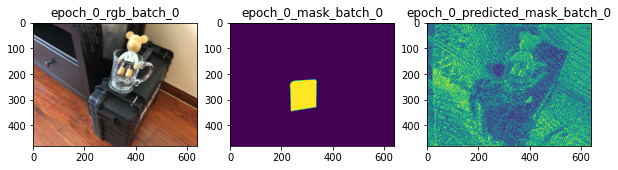

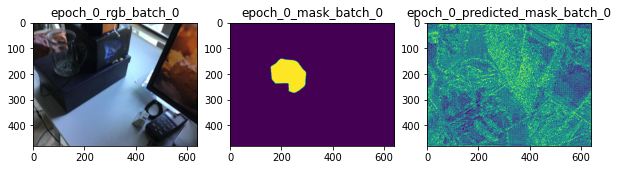

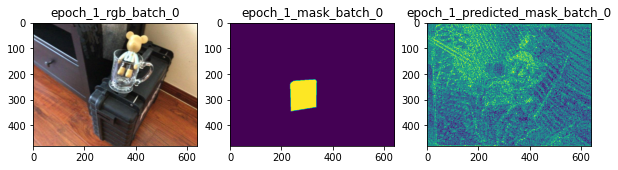

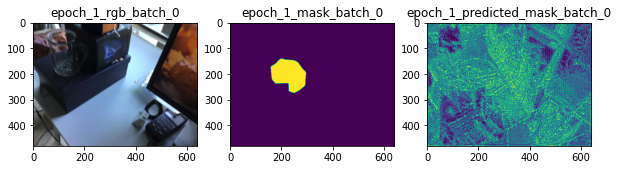

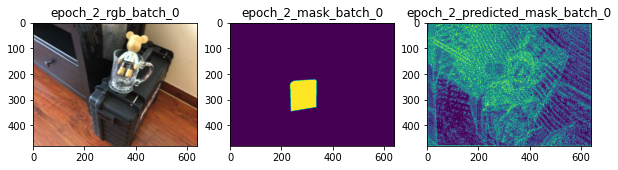

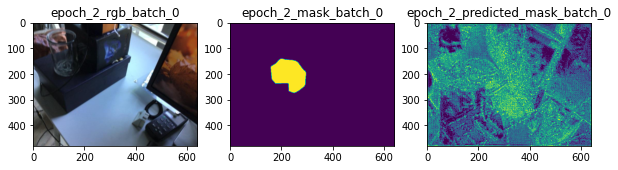

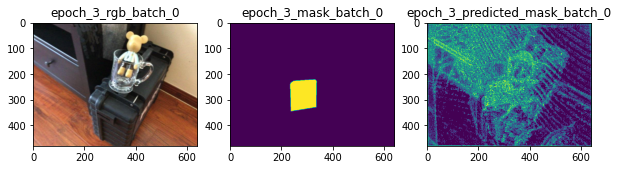

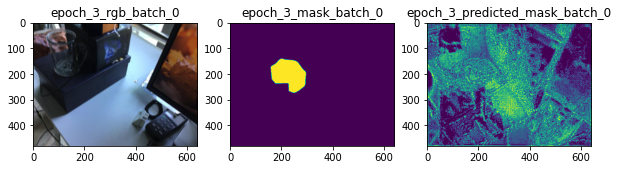

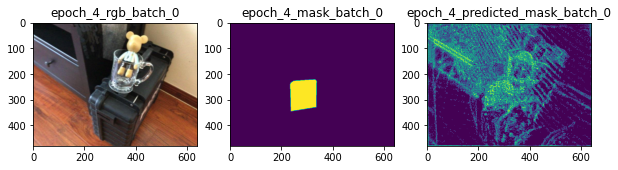

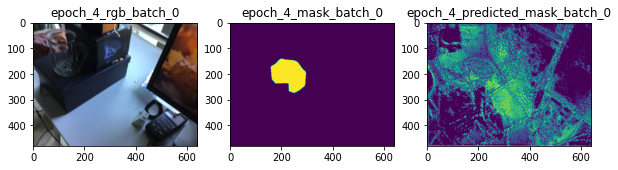

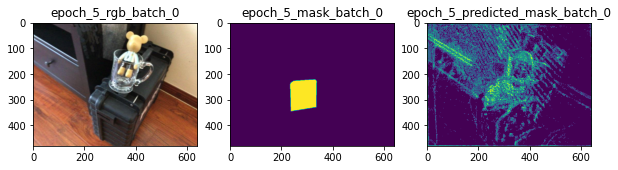

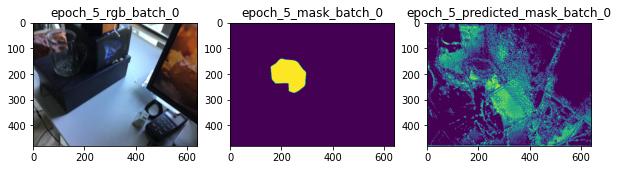

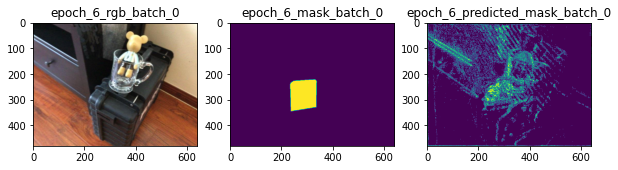

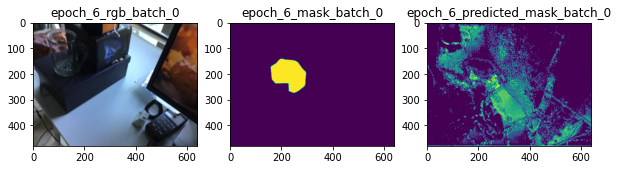

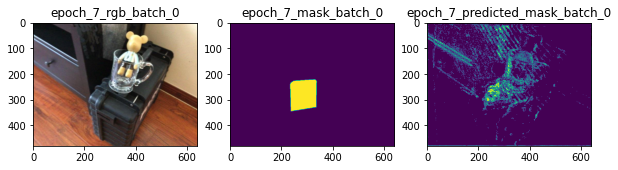

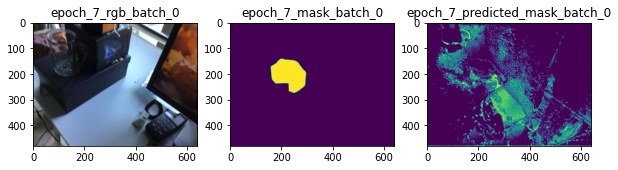

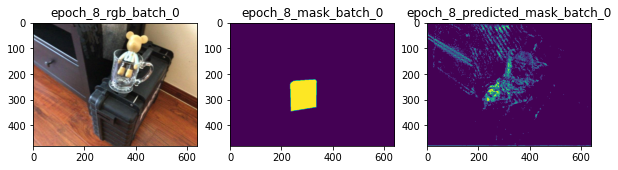

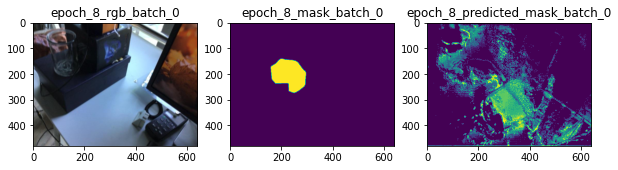

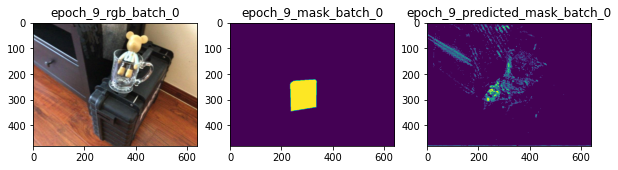

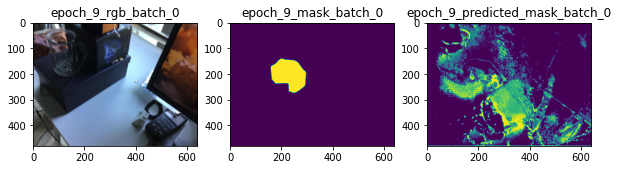

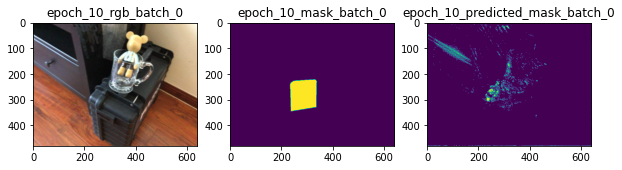

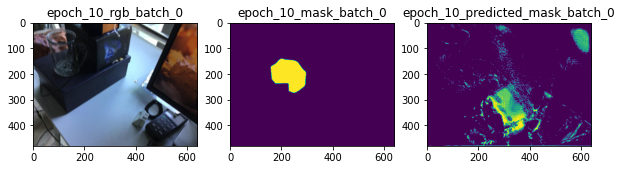

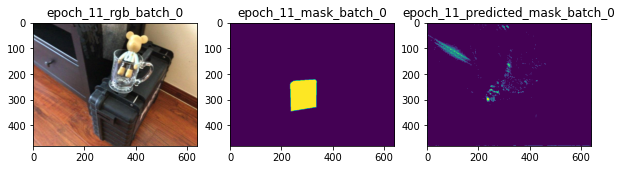

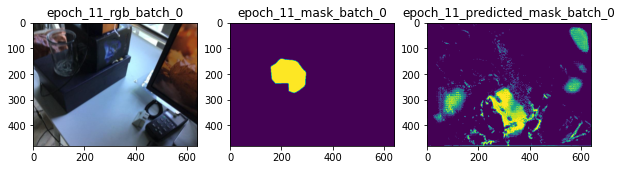

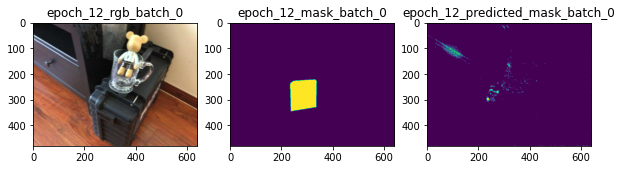

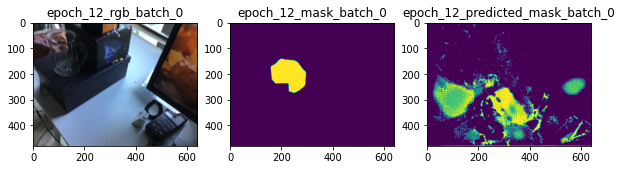

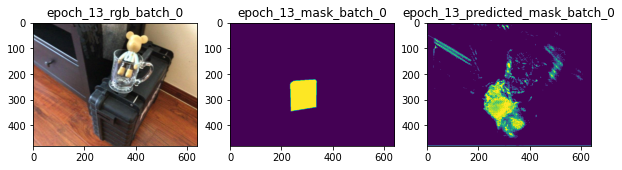

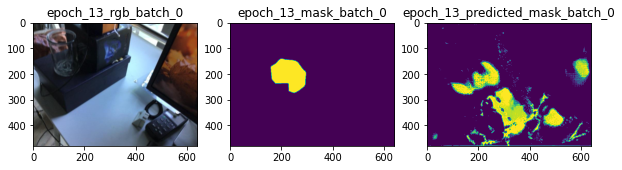

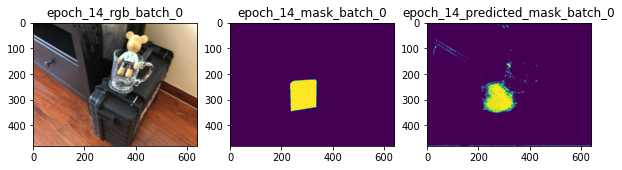

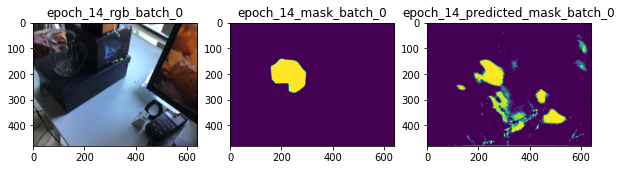

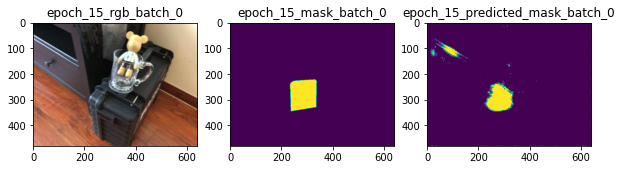

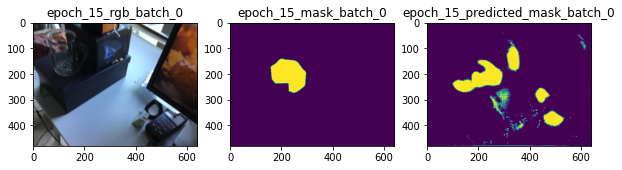

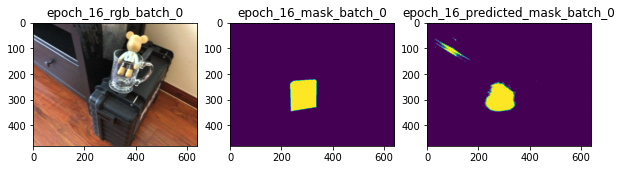

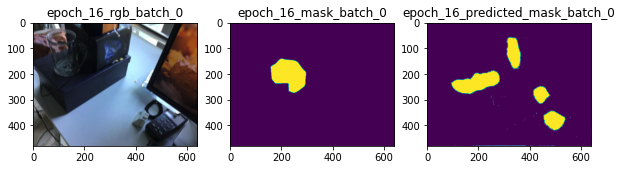

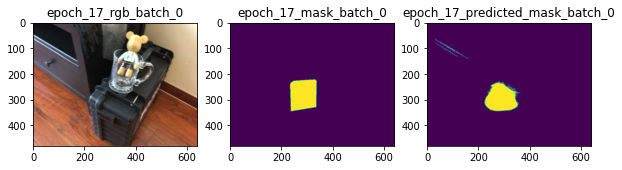

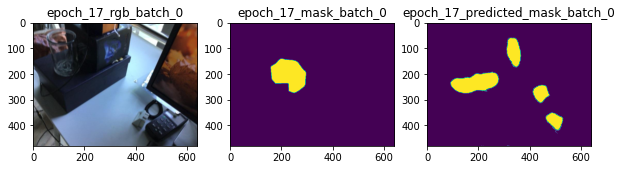

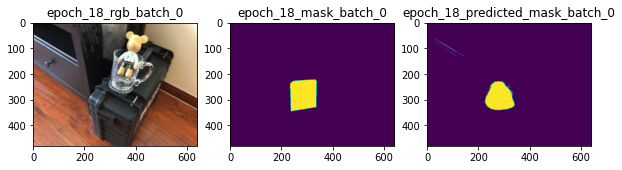

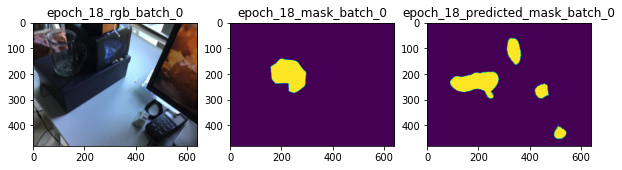

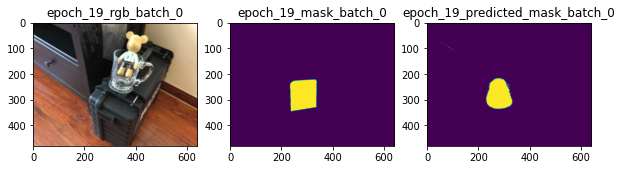

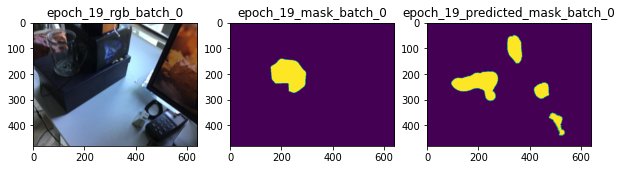

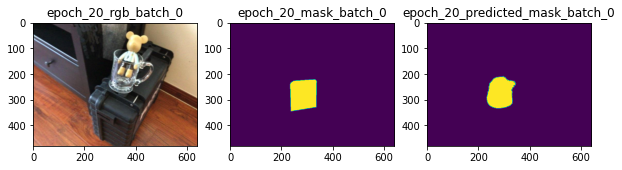

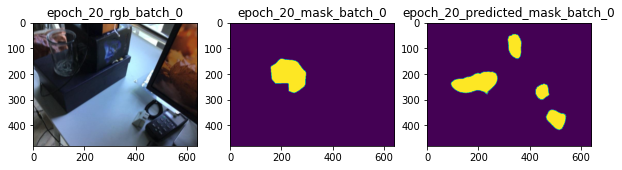

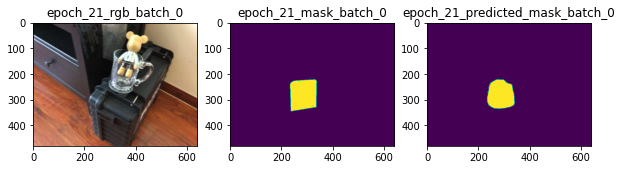

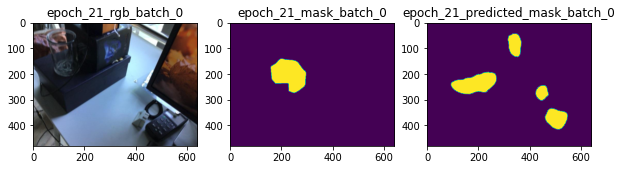

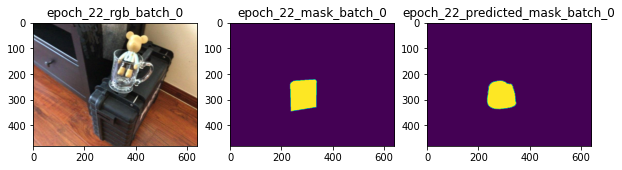

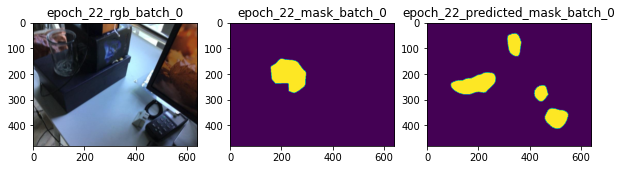

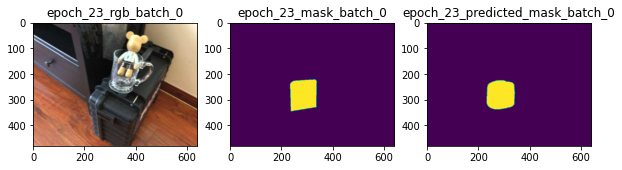

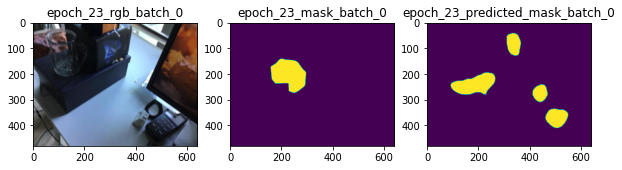

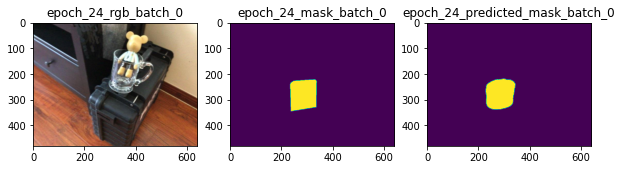

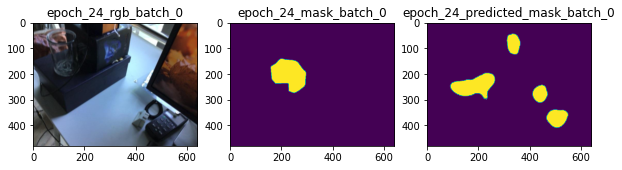

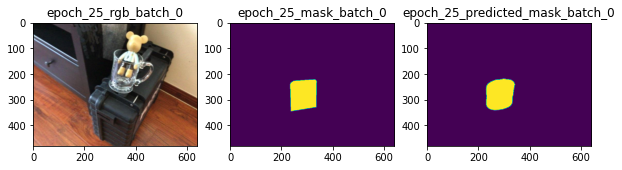

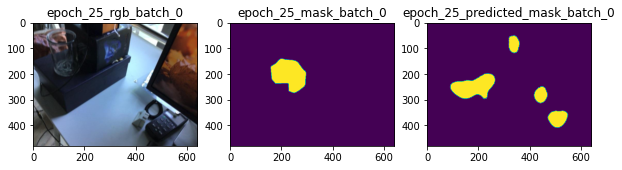

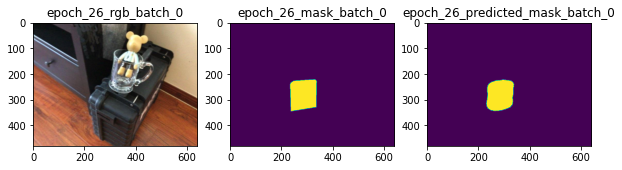

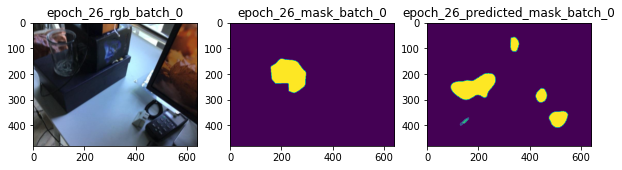

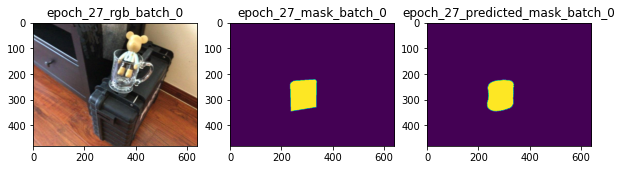

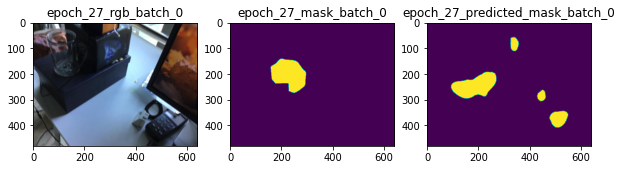

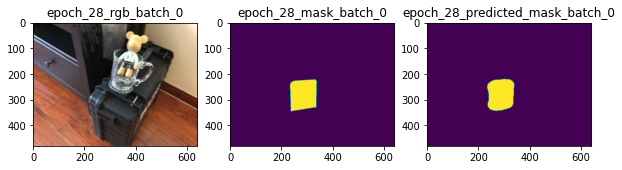

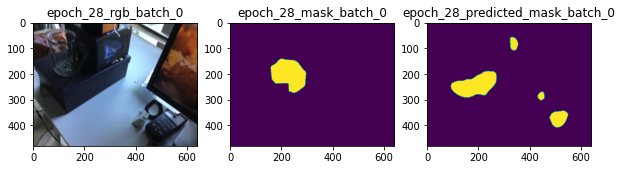

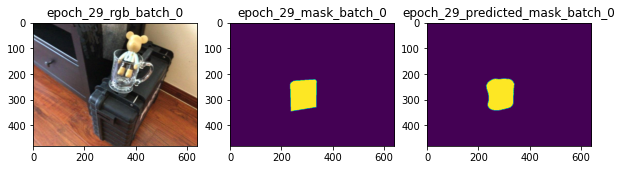

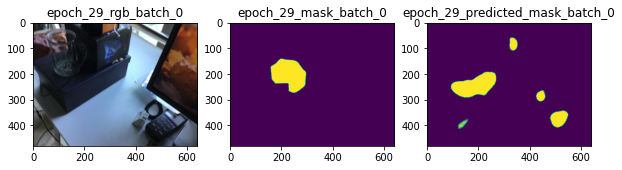

In [9]:
def main():

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #wont't work on my gpu
    ENABLE_GPU = True
    num_epochs = 30
    batch_size = 1
    #Generating a csv file for dataset
    if os.path.isfile('train/csv_file.csv') == False:
        Generate_csv_logs_for_images(column_names= ['rgb_names', 'depth_names', 'mask_names', 'Mirror','Transparent']
                                ,rgb_path = 'train/rgb'
                                ,depth_path = 'train/depth'
                                ,mask_path = 'train/mask'
                                ,mirror_path = 'train/train_mirror.txt'
                                ,transparent_path= 'train/train_trans.txt'
                                )

    #loading dataset
    dataset_input = COSD_Dataset_Loader(rgb_dir_path= 'train/rgb'
                            , depth_dir_path= 'train/depth'
                            , csv_file_path= 'train/csv_file.csv'
                            , mask_dir_path= 'train/mask'
                            , data_type= 'i'
                            , transform = transforms.Compose([ToTensor()]))

    
    # performing train test split
    datasets = dataset_train_test_split(dataset_input)
    trainDataset, testDataset = datasets['train'], datasets['val']

    #visualizing data. look png file in plots/dataset_sample.png
    if not os.path.exists('plots/dataset_sample.png'):
        visualizeData(dataset= trainDataset, show=False)


    #Creating Meta Data
    IoU_training_data = np.zeros(shape= (num_epochs,1))
    IoU_testing_data = np.zeros(shape= (num_epochs,1))
    rmse_train = np.zeros(shape= (num_epochs,1))
    rmse_test = np.zeros(shape= (num_epochs,1))
    cross_entropy_loss_train = np.zeros(shape= (num_epochs,1))
    cross_entropy_loss_test = np.zeros(shape= (num_epochs,1))
    if not os.path.exists('./plots/TrainMasks'):
            os.makedirs('./plots/TrainMasks')

    if not os.path.exists('./plots/TestMasks'):
        os.makedirs('./plots/TestMasks')
    
    trainData = torch.utils.data.DataLoader(dataset = trainDataset, batch_size= batch_size, shuffle= False)
    validationData = torch.utils.data.DataLoader(dataset = testDataset, batch_size = batch_size, shuffle = False)
    network = UNet(n_classes=3)
    if ENABLE_GPU:
        network.to(device) 
    optimizer = optim.Adam(network.parameters(),lr= 1e-4)
    
    #Starting epochs
    for epoch in range(num_epochs):
        print(f'Start of Epoch {epoch+1}/{num_epochs}')
        if epoch!=0 and os.path.exists(f'./checkpoints/epoch_{epoch}.pt'):
            checkpoint = load_checkpoint(f'./checkpoints/epoch_{epoch}.pt')
            try:
                network.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                training_loss = checkpoint['training_loss']
                testing_loss = checkpoint['testing_loss']
                epochs_completed = checkpoint['epoch']
            except Exception as e:
                print(e)
        """although we have 2 classes but those classes are labelled as 1 and 2 in the mask images. 
        So if n_classes =2 , loss function would by default consider 0 and 2, hence would give an out of bounds error"""
        #training loop
        for batch_i, batch in enumerate(trainData):
            rgb_batch = batch['rgb_image']/255
            depth_batch = batch['depth_image']/255
            mask_batch = torch.squeeze(input= batch['mask_image'].type(torch.LongTensor), dim= 1)
            if ENABLE_GPU:
                rgb_batch = rgb_batch.to(device)
                depth_batch = depth_batch.to(device)
                mask_batch = mask_batch.to(device)
            logits = network.forward(rgb_batch, depth_batch)
            cross_entropy_loss = nn.CrossEntropyLoss()
            cross_entropy_loss_value = cross_entropy_loss(logits, mask_batch)
            prediction = torch.argmax(logits, dim= 1)
                        
            optimizer.zero_grad()
            grad = cross_entropy_loss_value.backward()   
            optimizer.step()

            r = np.random.randint(0, batch_size)
            plot_comparison(path = 'plots/TrainMasks',epoch= epoch, batch_i = batch_i,
                            mask_image= mask_batch[r] , 
                            predicted_image= prediction[r],
                            actual_image = rgb_batch[r])
            if batch_i == 0:
                break

        cross_entropy_loss_train[epoch,] = torch.Tensor.cpu(cross_entropy_loss_value.detach())

        #testing loop
        for batch_i, batch in enumerate(validationData):
            with torch.no_grad():
                rgb_batch = batch['rgb_image']/255
                depth_batch = batch['depth_image']/255
                mask_batch = torch.squeeze(input= batch['mask_image'].type(torch.LongTensor), dim=1)
                if ENABLE_GPU:
                    rgb_batch = rgb_batch.to(device)
                    depth_batch = depth_batch.to(device)
                    mask_batch = mask_batch.to(device)
                    
                logits = network.forward(rgb_batch, depth_batch)
                cross_entropy_loss = nn.CrossEntropyLoss()
                cross_entropy_loss_value = cross_entropy_loss(logits, mask_batch)
                prediction = torch.argmax(logits, dim= 1)

            r = np.random.randint(0,batch_size)
            plot_comparison(path = 'plots/TestMasks',epoch= epoch, batch_i = batch_i,
                            mask_image= mask_batch[r] , 
                            predicted_image= prediction[r],
                            actual_image = rgb_batch[r])

            if batch_i == 0:
                break

        cross_entropy_loss_test[epoch,] = torch.Tensor.cpu(cross_entropy_loss_value)

        IoU_training_data[epoch,] = 0
        IoU_testing_data[epoch,] = 0
        rmse_train[epoch,] = 0
        rmse_test[epoch,] = 0
            
        print(f'Training Loss: {cross_entropy_loss_train[epoch]} and Testing Loss: {cross_entropy_loss_test[epoch]}')  
        
        create_checkpoint(model = network, optimizer= optimizer, epoch= epoch
                        , training_loss = cross_entropy_loss_train[epoch]
                        , testing_loss= cross_entropy_loss_test[epoch]
                        , path= './checkpoints')
        
        #save results of epoch: pending

        print(f'End of Epoch {epoch+1}/{num_epochs}')
            
        


if __name__ == '__main__': main()

